In [9]:
import os
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
tf.random.set_seed(1337)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2

TOKENIZER_MAX_WORDS = 10000

data = pd.concat([chunk for chunk in tqdm(pd.read_csv("../clean_dataset.csv", chunksize=1000), desc="loading dataset")])

train_data, test_data = train_test_split(data, test_size=TEST_SPLIT, random_state=1337, stratify=data["label"])


print("--------------------------------------------")
print("--------------------------------------------")
label_counts = train_data["label"].value_counts()
print(label_counts)
count_0 = label_counts[0]
count_1 = label_counts[1]
print(f"Number of 0 labels: {count_0}")
print(f"Number of 1 labels: {count_1}")
print("--------------------------------------------")
test_label_counts = test_data["label"].value_counts()
print(test_label_counts)
test_count_0 = test_label_counts[0]
test_count_1 = test_label_counts[1]
print(f"Number of test 0 labels: {test_count_0}")
print(f"Number of test 1 labels: {test_count_1}")
print("--------------------------------------------")
print("--------------------------------------------")


print(f"train data shape: {train_data.shape}")
print(f"test data shape:  {test_data.shape}")

print(f"tokenizing the test dataset")
tokenizer = Tokenizer(num_words=TOKENIZER_MAX_WORDS)
tokenizer.fit_on_texts(train_data["text"])

loaded_models = tf.keras.models.load_model("../models/lstm.keras")

X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["text"]), maxlen=250) # TODO: CHANGE 500 TO REFLECT THE MODEL PARAMS
Y_test = test_data["label"]

y_pred_model = loaded_models.predict(X_test)

loading dataset: 50it [00:00, 120.99it/s]


--------------------------------------------
--------------------------------------------
label
1    20000
0    20000
Name: count, dtype: int64
Number of 0 labels: 20000
Number of 1 labels: 20000
--------------------------------------------
label
1    5000
0    5000
Name: count, dtype: int64
Number of test 0 labels: 5000
Number of test 1 labels: 5000
--------------------------------------------
--------------------------------------------
train data shape: (40000, 2)
test data shape:  (10000, 2)
tokenizing the test dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step


y_pred_classes
[[9.9418730e-01]
 [3.1016207e-01]
 [9.9213451e-01]
 ...
 [6.8117864e-05]
 [4.8050350e-03]
 [7.0003269e-04]]


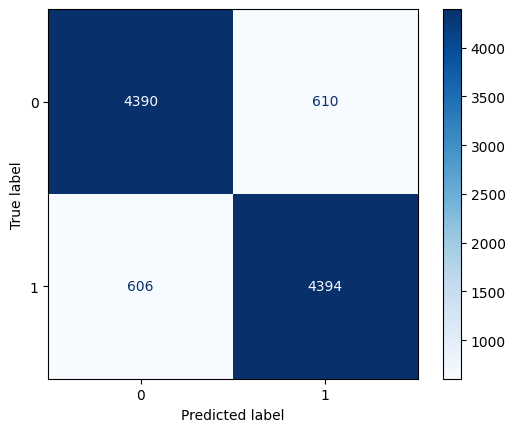

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
print(f"y_pred_classes\n{y_pred_model}")

threshold = 0.5
y_pred_labels = (y_pred_model >= threshold).astype(int)
conf_matrix = confusion_matrix(test_data["label"], y_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [11]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["text"]), maxlen=500) # TODO: CHANGE 500 TO REFLECT THE MODEL PARAMS
# y_pred_model = loaded_models.predict(X_test).argmax(axis=-1)


# metrics = loaded_models.evaluate(X_test, Y_test)
# print(f"LSTM with hyperparameters")
# print(f"metrics: {metrics}")

from sklearn.metrics import accuracy_score, recall_score, f1_score

y_pred = loaded_models.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(Y_test, y_pred_binary)
recall = recall_score(Y_test, y_pred_binary)
f1 = f1_score(Y_test, y_pred_binary)

with open("TMP_hyp_lstm.txt", "a") as file:
  file.write(f"LSTM with hyperparameters")
  file.write(f"accuracy:      {accuracy}")
  file.write(f"test recall:   {recall}\n")
  file.write(f"test f1:       {f1}\n\n")

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step
Accuracy:  0.8791
Precision: 0.8791
Recall:    0.8791
F1 Score:  0.8791


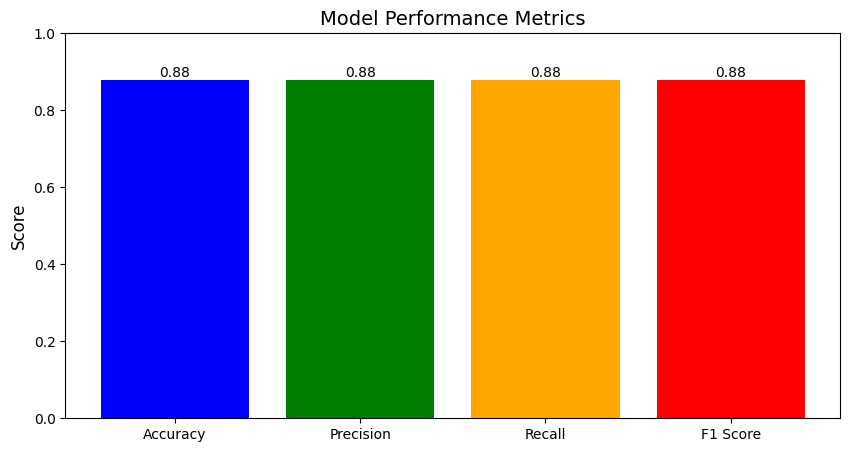

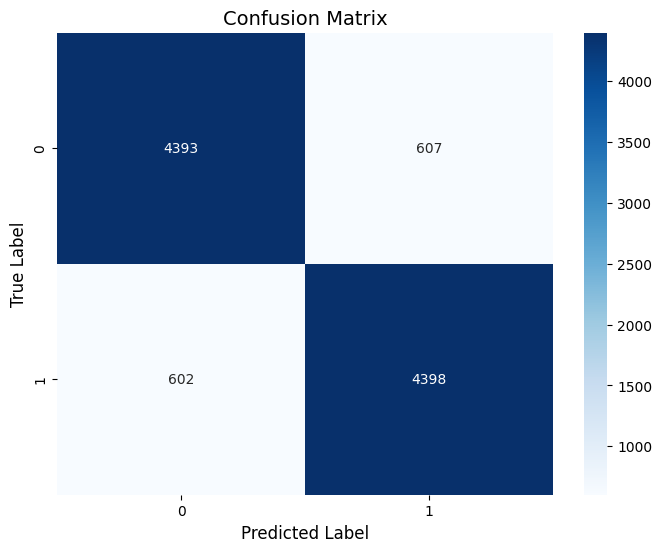

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix)

# Generate predictions
y_pred = loaded_models.predict(X_test)

# Convert predictions to class labels
if y_pred.shape[-1] > 1:  # Multi-class classification
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(Y_test, axis=1)
else:  # Binary classification
  y_pred_labels = (y_pred > 0.5).astype(int).squeeze()
  y_true_labels = Y_test.squeeze()

# Calculate metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Print metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot metrics
plt.figure(figsize=(10, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Performance Metrics', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)

# Add values on top of bars
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2., height,
    f'{height:.2f}',
    ha='center', va='bottom')

plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
  xticklabels=np.unique(y_true_labels), 
  yticklabels=np.unique(y_true_labels))
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Usage example:
# plot_metrics_and_confusion_matrix(model, X_test, Y_test)